<a href="https://colab.research.google.com/github/LeonimerMelo/Reinforcement-Learning/blob/Q-Learning/Rob%C3%B3tica_Navega%C3%A7%C3%A3o_em_Ambientes_%5BQ_Learning_RL%5D_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Robótica: Navegação em Ambientes

Este notebook apresenta os passos para implementar uma solução de navegação em ambientes usando Processos de Decisão de Markov (MDPs) e Aprendizado por Reforço (RL).

---

### **Etapa 1: Definir o Ambiente**
O ambiente é um grid 2D onde o robô se move para alcançar um objetivo, evitando obstáculos.

1. **Configuração do Grid**:
   - Cada célula do grid representa um estado $ S $.
   - As células podem ser:
     - **Caminháveis**: Estados válidos para o robô.
     - **Obstáculos**: Estados bloqueados.
     - **Objetivo**: Estado final desejado.

2. **Exemplo de Ambiente**:
   ```
   S = Início
   X = Obstáculo
   G = Objetivo

   [ S, 0, 0, G ]
   [ 0, X, 0, 0 ]
   [ 0, 0, X, 0 ]
   ```

---

### **Etapa 2: Modelar o MDP**
Defina os elementos do MDP para o problema.

1. **Estados ($S$)**:
   - Cada posição do grid $ (x, y) $ é um estado.

2. **Ações ($A$)**:
   - $ A = \{ \text{cima}, \text{baixo}, \text{esquerda}, \text{direita} \} $.

3. **Probabilidade de Transição ($P(s'|s, a)$)**:
   - Probabilidade de $80\%$ de mover na direção escolhida.
   - Probabilidade de $20\%$ de mover para uma direção vizinha aleatória.

4. **Recompensas ($R(s, a)$)**:
   - $+10$ ao alcançar o objetivo.
   - $-1$ por movimento.
   - $-100$ ao colidir com um obstáculo.

5. **Fator de Desconto ($\gamma$)**:
   - $ \gamma = 0.9 $: Prioriza recompensas futuras, mas dá mais peso às imediatas.

---

### **Etapa 3: Escolher um Algoritmo de RL**
Escolha um algoritmo para resolver o MDP:
- **Q-Learning** (sem modelo): Aprende a função $ Q(s, a) $, que estima a qualidade de cada ação em um estado.
- **SARSA**: Similar ao Q-Learning, mas considera a política atual.
- **Deep Q-Learning**: Usa redes neurais para lidar com espaços de estado maiores.

---



### **Etapa 4: Implementação**
Aqui está um exemplo de implementação básica usando Q-Learning.

In [1]:
# Bibliotecas Necessárias
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#### Configuração do Ambiente:

In [2]:
# i_state = (4, 0)  # Estado inicial
i_state = (2, 0)  # Estado inicial

# Representação do grid
# -1 = Obstáculo, 0 = Caminhável, 1 = Objetivo
# grid = np.array([
#     [0, 0, 0, 0, 0, 1],
#     [0, -1, 0, 0, 0, 0],
#     [0, 0, -1, 0, -1, 0],
#     [-1, 0, 0, 0, 0, 0],
#     [0, 0, -1, 0, 0, 0]
# ])
grid = np.array([
    [0, 0, 0, 1],
    [0, -1, 0, 0],
    [0, 0, -1, 0]
])
rows, cols = grid.shape
a = np.where(grid == 1)
g_state = (a[0][0], a[1][0]) # goal state (estado final)

# Recompensas
rewards = np.full((rows, cols), -1)
rewards[g_state] = 10  # Objetivo
lin_i, col_i = np.where(grid == -1)
for i in range(len(lin_i)):
  rewards[lin_i[i], col_i[i]]= -100 # obstáculos

In [3]:
grid

array([[ 0,  0,  0,  1],
       [ 0, -1,  0,  0],
       [ 0,  0, -1,  0]])

In [4]:
rows, cols

(3, 4)

In [5]:
rewards

array([[  -1,   -1,   -1,   10],
       [  -1, -100,   -1,   -1],
       [  -1,   -1, -100,   -1]])

In [ ]:
g_state

(0, 3)

###Funções Auxiliares:

In [6]:
# Função para determinar se o estado é válido
def is_valid_state(state):
    x, y = state
    return 0 <= x < rows and 0 <= y < cols and grid[x, y] != -1

# Função para obter o próximo estado
def get_next_state(state, action):
    x, y = state
    if action == "up":
        x -= 1
    elif action == "down":
        x += 1
    elif action == "left":
        y -= 1
    elif action == "right":
        y += 1
    return (x, y) if is_valid_state((x, y)) else state

# Exibir a Q-Table como DataFrame
# Criar um DataFrame para cada estado e ação
def display_q_table(q_table):
    states = [(row, col) for row in range(rows) for col in range(cols)]
    data = []
    for state in states:
        if grid[state[0], state[1]] == -1:  # Marcar obstáculos
            data.append(["OBST", "OBST", "OBST", "OBST"])
        else:
            data.append(q_table[state].round(2))  # Valores Q para cada ação
    df = pd.DataFrame(data, index=states, columns=['Up', 'Down', 'Left', 'Right'])
    return df

In [7]:
is_valid_state((3,3))

False

### **Atualização da Q-Table**
Os valores Q na tabela são atualizados iterativamente durante o treinamento. A fórmula de atualização é:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Explicando a equação:

Novo Valor Q = Valor Q antigo + taxa de aprendizado * (recompensa + fator de desconto * valor Q máximo do próximo estado - Valor Q antigo)


- $s$: Estado atual.
- $a$: Ação tomada.
- $r$: Recompensa recebida após executar a ação $a$ em $s$.
- $s'$: Próximo estado alcançado.
- $\alpha$: Taxa de aprendizado (determina o peso dado à nova informação).
- $\gamma$: Fator de desconto (determina a importância das recompensas futuras).
- $\max_{a'} Q(s', a')$: Melhor valor Q estimado no próximo estado $s'$.

###Implementação do Q-Learning:

In [11]:
# Parâmetros do Q-Learning
actions = ["up", "down", "left", "right"]
q_table = np.zeros((rows, cols, len(actions)))
alpha = 0.1  # Taxa de aprendizado
gamma = 0.9  # Fator de desconto
epsilon = 0.1  # Taxa de exploração
episodes = 1000  # número de epsódios
max_step_time = 100 # número máximo de iterações (step time) por episódios
e_print = 1000  # episódio para imprimir as ações tomadas

# Monitorar métricas durante o treinamento
#valores_Q = []
rewards_per_episode = []
steps_per_episode = []
q_table_history = []

# Treinamento
for episode in range(episodes):
    state = i_state  # Estado inicial
    steps=0
    total_reward=0
    while state != g_state:  # Até alcançar o objetivo
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Exploration
        else:
            action = actions[np.argmax(q_table[state[0], state[1]])]  # Exploitation

        next_state = get_next_state(state, action)
        reward = rewards[next_state[0], next_state[1]]
        action_index = actions.index(action)

        # Atualizar a Q-Table
        best_next_action = np.max(q_table[next_state[0], next_state[1]])
        q_table[state[0], state[1], action_index] += alpha * (
            reward + gamma * best_next_action - q_table[state[0], state[1], action_index]
        )
        #print(i, action, state, reward, end=" ")
        state = next_state
        total_reward += reward

        #print(steps, action, state, reward, end=" ")
        if (e_print-1 == episode):
          print('step time:', steps, '\taction:', action, '\treward:', reward)

        steps+=1
        if steps > max_step_time:
          print('Máximo de iterações atingida! steps:', steps, 'episódio:', episode)
          break

    #valores_Q.append(q_table[0, 0])
    rewards_per_episode.append(total_reward)
    steps_per_episode.append(steps)
    q_table_history.append(np.mean(q_table))  # Armazenar média geral da Q-Table
    #print(episode, state, reward, i, end=" ")

step time: 0 	action: up 	reward: -1
step time: 1 	action: up 	reward: -1
step time: 2 	action: right 	reward: -1
step time: 3 	action: right 	reward: -1
step time: 4 	action: right 	reward: 10


##Explicação passo-a-passo do Q-Learning
---

Parâmetros e condições iniciais

In [ ]:
# Parâmetros do Q-Learning
actions = ["up", "down", "left", "right"]
q_table = np.zeros((rows, cols, len(actions)))
alpha = 0.1  # Taxa de aprendizado
gamma = 0.9  # Fator de desconto
epsilon = 0.1  # Taxa de exploração

In [ ]:
state = i_state  # Estado inicial
steps = 0

###Aqui começa o Looping dos time steps

In [ ]:
# Verifico a Q-table
q_table

array([[[ 0.14723957, -0.65717909,  0.94813972,  6.18631887],
        [ 1.49065112, -0.199     ,  0.67012854,  7.99717604],
        [ 1.48189588, -0.19      ,  1.38753576,  9.99970487],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 4.52912978, -0.67054826, -0.45235423, -0.87249359],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.1       , -0.1       , -0.1       , -0.1       ],
        [ 1.        ,  0.        ,  0.        ,  0.        ]],

       [[ 2.98866651, -1.63532611, -1.66650156, -2.02764151],
        [-1.9836941 , -1.9836941 , -1.36861136, -1.9836941 ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]])

In [ ]:
# Verifico o estado atual
state

(2, 0)

In [ ]:
# verifico o posicionamento (estado) no grid
# -1 = Obstáculo, 0 = Caminhável, 1 = Objetivo
grid

array([[ 0,  0,  0,  1],
       [ 0, -1,  0,  0],
       [ 0,  0, -1,  0]])

In [ ]:
# Linha da Q-table correspondente ao estado atual.
# Os valores correspondem aos "pesos" das respectivas ações: ["up", "down", "left", "right"]
q_table[state[0], state[1]]

array([ 2.98866651, -1.63532611, -1.66650156, -2.02764151])

In [ ]:
# índice da ação de maior "peso"
np.argmax(q_table[state[0], state[1]])

0

In [ ]:
# decisão randômica: Exploration ou Exploitation?
# Taxa de exploração: epsilon = 0.1 -->
# 10% de chance para Exploration e 90% de chance para Exploitation
if random.uniform(0, 1) < epsilon:
    action = random.choice(actions)  # Exploration
    print('Exploration')
else:
    action = actions[np.argmax(q_table[state[0], state[1]])]  # Exploitation
    print('Exploitation')

Exploitation


In [ ]:
# nova ação a ser tomada
action

'up'

In [ ]:
# novo estado após ser tomada a nova ação
next_state = get_next_state(state, action)
next_state

(1, 0)

In [ ]:
# Vefica se a ação foi válida!
if(next_state != state):
  print('Valid new state')
else:
  print('New state invalid. Keep state!')

Valid new state


In [ ]:
# grid de recompensas
rewards

array([[  -1,   -1,   -1,   10],
       [  -1, -100,   -1,   -1],
       [  -1,   -1, -100,   -1]])

In [ ]:
# recompensa ganha ao atingir o novo estado
reward = rewards[next_state[0], next_state[1]]
reward

-1

In [ ]:
# índice da ação --> ações: ["up", "down", "left", "right"]
action_index = actions.index(action)
action_index

0

In [ ]:
# Linha da Q-table correspondente ao novo estado
# Os valores correspondem aos "pesos" das respectivas ações: ["up", "down", "left", "right"]
q_table[next_state[0], next_state[1]]

array([ 4.52912978, -0.67054826, -0.45235423, -0.87249359])

In [ ]:
# Seleciono a ação de peso máximo!
best_next_action = np.max(q_table[next_state[0], next_state[1]])
best_next_action

4.529129784811477

In [ ]:
# índice da ação de maior "peso"
i_new = np.argmax(q_table[next_state[0], next_state[1]])
i_new

0

In [ ]:
# nova ação selecionada
actions[i_new]

'up'

In [ ]:
# valor da Q-table da nova ação selecionada
q_table[state[0], state[1], action_index]

4.529129784811477

In [ ]:
# Atualizar a Q-Table utilizando a fórmula de atualização do Q-Learning
# Novo Valor Q = Valor Q antigo + taxa de aprendizado *
#   (recompensa + fator de desconto * valor Q máximo do próximo estado - Valor Q antigo)
q_table[state[0], state[1], action_index] += alpha * (
    reward + gamma * best_next_action - q_table[state[0], state[1], action_index])

In [ ]:
# Novo Valor da Q-Table
q_table[state[0], state[1], action_index]

4.383838486963363

In [ ]:
q_table

array([[[ 0.14723957, -0.65717909,  0.94813972,  6.18631887],
        [ 1.49065112, -0.199     ,  0.67012854,  7.99717604],
        [ 1.48189588, -0.19      ,  1.38753576,  9.99970487],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 4.38383849, -0.67054826, -0.45235423, -0.87249359],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.1       , -0.1       , -0.1       , -0.1       ],
        [ 1.        ,  0.        ,  0.        ,  0.        ]],

       [[ 2.99742154, -1.63532611, -1.66650156, -2.02764151],
        [-1.9836941 , -1.9836941 , -1.36861136, -1.9836941 ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]])

In [ ]:
# Exibir a Q-Table como DataFrame
q_table_df = display_q_table(q_table)
print(q_table_df)

          Up  Down  Left Right
(0, 0)  0.15 -0.66  0.95  6.19
(0, 1)  1.49  -0.2  0.67   8.0
(0, 2)  1.48 -0.19  1.39  10.0
(0, 3)   0.0   0.0   0.0   0.0
(1, 0)  4.38 -0.67 -0.45 -0.87
(1, 1)  OBST  OBST  OBST  OBST
(1, 2)  -0.1  -0.1  -0.1  -0.1
(1, 3)   1.0   0.0   0.0   0.0
(2, 0)   3.0 -1.64 -1.67 -2.03
(2, 1) -1.98 -1.98 -1.37 -1.98
(2, 2)  OBST  OBST  OBST  OBST
(2, 3)   0.0   0.0   0.0   0.0


In [ ]:
# O novo estado passa a ser o estado atual
state = next_state
state

(1, 0)

In [ ]:
# incremento o step time
steps+=1
steps

1

**Retornar ao loop dos time steps**

---

#Métricas

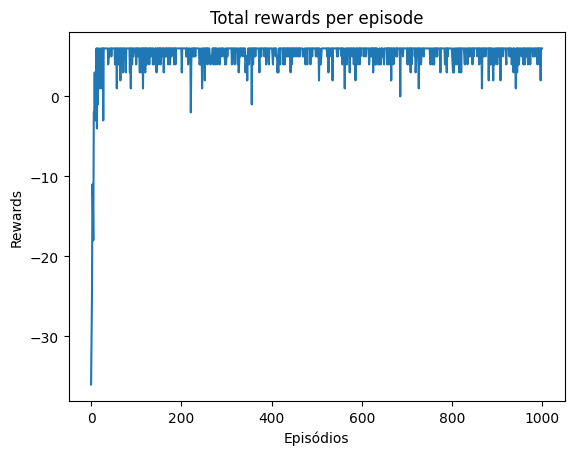

In [17]:
# Gráfico Total rewards per episode
plt.plot(rewards_per_episode)
plt.xlabel('Episódios')
plt.ylabel('Rewards')
plt.title('Total rewards per episode')
plt.show()

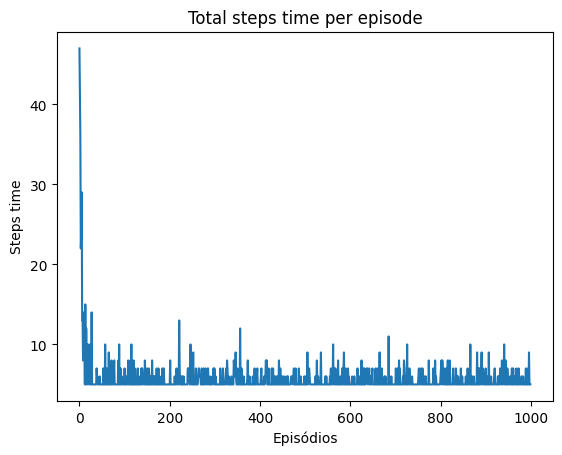

In [16]:
# Gráfico Total steps per episode
plt.plot(steps_per_episode)
plt.xlabel('Episódios')
plt.ylabel('Steps time')
plt.title('Total steps time per episode')
plt.show()

###Média dos valores da Q-Table
Média geral dos valores da Q-Table ao longo de episódios de treinamento. Essa abordagem ajuda a monitorar como os valores Q evoluem durante o aprendizado.

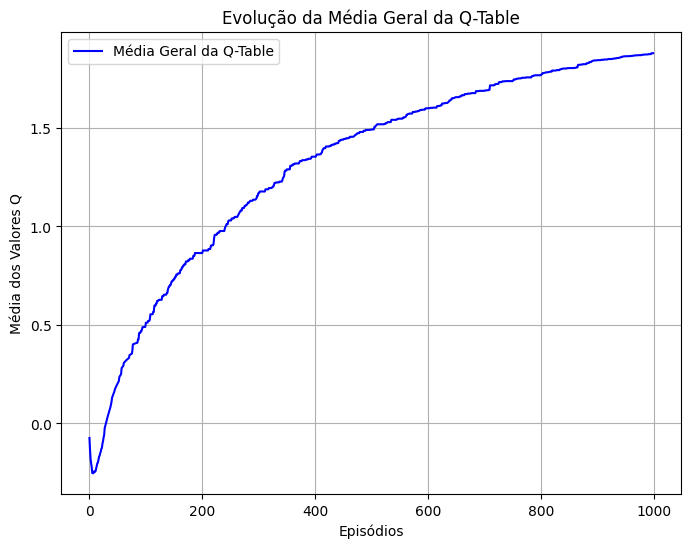

In [14]:
# Plotando a evolução da média geral da Q-Table
plt.figure(figsize=(8, 6))
plt.plot(q_table_history, label="Média Geral da Q-Table", color="blue")
plt.title("Evolução da Média Geral da Q-Table")
plt.xlabel("Episódios")
plt.ylabel("Média dos Valores Q")
plt.legend()
plt.grid(True)
plt.show()

1. **Cálculo da Média Geral:**
   - A média dos valores na Q-Table é calculada com `np.mean(q_table)`.
   - Isso representa a estimativa média da recompensa futura para todas as ações em todos os estados.
2. **Histórico da Média:**
   - Armazenamos a média geral após cada atualização da Q-Table.
   - Isso permite observar tendências de aprendizado (ex.: crescimento ou estabilização).
3. **Gráfico:**
   - O gráfico mostra como os valores da Q-Table evoluem ao longo do treinamento, indicando progresso.

#### Resultados Esperados
- **Curva Crescente:** À medida que o agente aprende a maximizar recompensas, a média da Q-Table deve crescer.
- **Estabilização:** Quando a política converge, a média da Q-Table tende a estabilizar.

In [15]:
q_table

array([[[ 4.16602157,  2.98054864,  4.38283606,  6.2       ],
        [ 5.81836494,  5.46935619,  4.27422158,  8.        ],
        [ 7.6422557 ,  4.39733865,  5.86842937, 10.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 4.58      ,  1.44833263,  2.53294391,  3.04213156],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 7.41849411,  0.32410585, -0.1       , -0.1       ],
        [ 1.9       ,  0.        ,  0.        ,  0.        ]],

       [[ 3.122     ,  1.16141019,  1.45867822, -0.94062553],
        [-2.08381456, -2.05076729,  1.14695105, -1.86823933],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]])

In [ ]:
# Exibir a Q-Table de forma organizada
def print_q_table(q_table):
    print("\nQ-Table:")
    for row in range(q_table.shape[0]):  # Para cada linha
        for col in range(q_table.shape[1]):  # Para cada coluna
            state = (row, col)
            if grid[row, col] == -1:  # Obstáculo
                print(f"({row},{col}): OBST", end=" | ")
            else:
                q_values = q_table[state]
                print(f"({row},{col}): {q_values.round(2)}", end=" | ")
        print()  # Nova linha para cada linha do grid

# Exibir a Q-Table
print_q_table(q_table)



Q-Table:
(0,0): [4.04 2.87 4.11 6.2 ] | (0,1): [4.74 6.04 3.88 8.  ] | (0,2): [ 7.53  4.43  5.87 10.  ] | (0,3): [0. 0. 0. 0.] | 
(1,0): [4.58 1.66 2.85 2.87] | (1,1): OBST | (1,2): [7.48 0.   1.29 0.  ] | (1,3): [0. 0. 0. 0.] | 
(2,0): [3.12 1.62 1.53 0.06] | (2,1): [-1.73 -1.65  1.66 -1.74] | (2,2): OBST | (2,3): [0. 0. 0. 0.] | 


In [ ]:
# Exibir a Q-Table como DataFrame
q_table_df = display_q_table(q_table)
print(q_table_df)

          Up  Down  Left Right
(0, 0)   0.0   0.0   0.0   0.0
(0, 1)   0.0   0.0   0.0   0.0
(0, 2)   0.0   0.0   0.0   0.0
(0, 3)   0.0   0.0   0.0   0.0
(1, 0)   0.0   0.0   0.0   0.0
(1, 1)  OBST  OBST  OBST  OBST
(1, 2)   0.0   0.0   0.0   0.0
(1, 3)   0.0   0.0   0.0   0.0
(2, 0)   0.0   0.0   0.0   0.0
(2, 1)   0.0   0.0   0.0   0.0
(2, 2)  OBST  OBST  OBST  OBST
(2, 3)   0.0   0.0   0.0   0.0


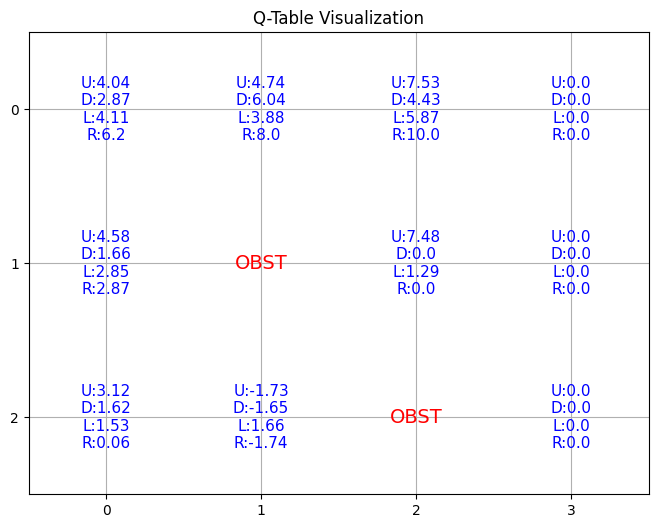

In [ ]:
import matplotlib.pyplot as plt

# Exibir os valores Q de forma gráfica
def plot_q_table(q_table):
    fig, ax = plt.subplots(figsize=(8, 6))
    for row in range(rows):
        for col in range(cols):
            state = (row, col)
            if grid[row, col] == -1:
                ax.text(col, rows - row - 1, "OBST", ha='center', va='center', color='red', fontsize=14)
            else:
                values = q_table[state].round(2)
                ax.text(col, rows - row - 1, f"U:{values[0]}\nD:{values[1]}\nL:{values[2]}\nR:{values[3]}",
                        ha='center', va='center', fontsize=11, color='blue')
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.set_xticklabels(range(cols))
    ax.set_yticklabels(range(rows - 1, -1, -1))
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(-0.5, rows - 0.5)
    ax.grid()
    ax.set_title("Q-Table Visualization")
    plt.show()

# Plotar a Q-Table
plot_q_table(q_table)


## Heatmap de Valores Médios da Q-Table
Podemos calcular os valores médios das ações em cada estado e mapeá-los para o ambiente.

###Explicação
- **Cálculo da Média:** `np.mean(q_table, axis=1)` calcula a média dos valores Q para todas as ações em cada estado.
- **Reshape para Grid:** O vetor de médias $\text{state_means}$ é transformado no formato $(linhas \times colunas)$ correspondente ao ambiente.
- **Heatmap:** O `seaborn.heatmap` gera o gráfico com as anotações dos valores em cada célula.

### Resultados Esperados
- Um **heatmap** onde cada célula representa o valor médio das ações em um estado do ambiente.
- Os valores altos aparecem em tons mais escuros (indicando estados melhores).
- Os valores baixos aparecem em tons mais claros.

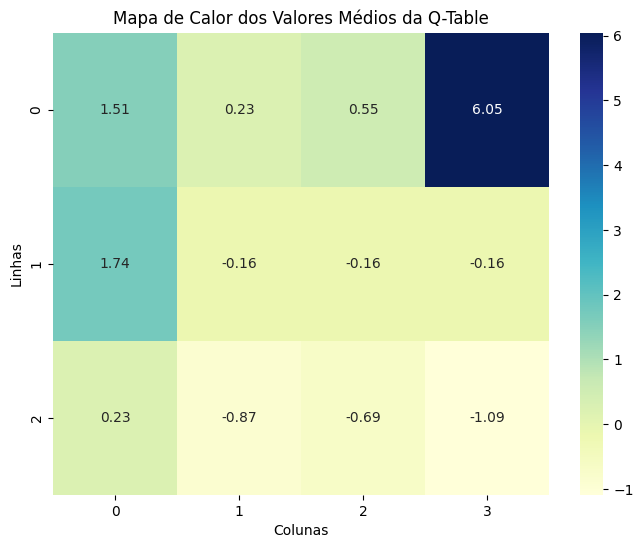

In [ ]:
import seaborn as sns  # Para heatmaps sofisticados

# Calcular o valor médio de cada estado
state_means = np.mean(q_table, axis=1)  # Média ao longo das ações

# Remodelar a matriz para o formato do grid
state_mean_matrix = state_means.reshape(rows, cols)

# Plotando o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(state_mean_matrix, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)
plt.title("Mapa de Calor dos Valores Médios da Q-Table")
plt.xlabel("Colunas")
plt.ylabel("Linhas")
plt.show()

In [ ]:
def plot_grid(grid, path, title="Caminho Percorrido pelo Robô"):
    rows, cols = grid.shape
    fig, ax = plt.subplots(figsize=(8, 6))

    # Configurar o grid
    for x in range(rows):
        for y in range(cols):
            # Configurar cores
            if grid[x, y] == -1:
                facecolor = "black"  # Obstáculo
                edgecolor = "gray"
            elif grid[x, y] == 1:
                facecolor = "green"  # Objetivo
                edgecolor = "gray"
            else:
                facecolor = "white"  # Caminho livre
                edgecolor = "gray"
            ax.add_patch(plt.Rectangle((y, x), 1, 1, facecolor=facecolor, edgecolor=edgecolor))

    # Adicionar o caminho do robô
    for i, (x, y) in enumerate(path):
        ax.text(y + 0.5, x + 0.5, str(i), ha="center", va="center", color="blue")

    # Configurações de layout
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title)
    ax.grid(True)
    plt.gca().invert_yaxis()  # Inverter o eixo Y
    plt.show()

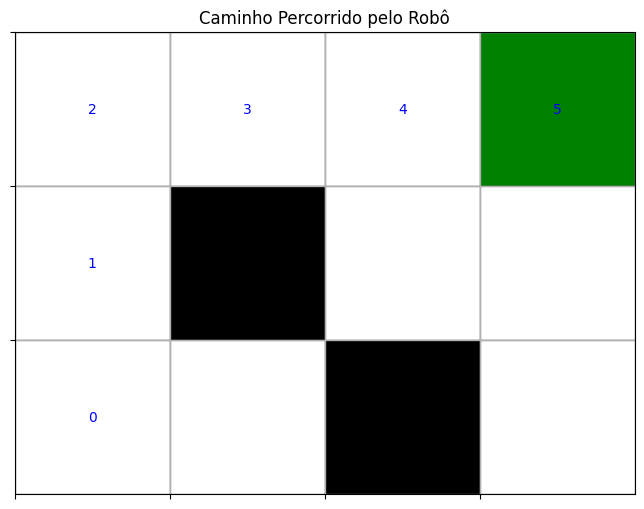

In [ ]:
# Simulação do caminho aprendido pelo robô
def simulate_path(q_table, start, goal):
    state = start
    path = [state]
    i=0
    while state != goal:
        # Selecionar a melhor ação com base na Q-Table
        action_index = np.argmax(q_table[state[0], state[1]])
        action = actions[action_index]
        state = get_next_state(state, action)
        path.append(state)
        i+=1
        if i > max_step_time:
          break
    return path

# Definir estado inicial e objetivo
start_state = i_state
goal_state = g_state

# Simular o caminho percorrido
path = simulate_path(q_table, start_state, goal_state)

# Exibir o grid e o caminho
plot_grid(grid, path, title="Caminho Percorrido pelo Robô")

### **Etapa 5: Avaliação**
1. **Executar a Política Aprendida**:
   - Use a Q-Table para escolher a ação $ \text{argmax}_{a} Q(s, a) $ em cada estado.

2. **Visualizar o Caminho**:
   - Imprima o caminho seguido pelo robô no grid.
   - Exemplo de visualização:
     ```
     [ S, ., ., G ]
     [ ., X, ., . ]
     [ ., ., X, . ]
     ```

3. **Métricas de Avaliação**:
   - Custo total (soma das recompensas).
   - Número de passos para alcançar o objetivo.

---

### **Etapa 6: Melhorias**
1. **Explorar Algoritmos Avançados**:
   - Deep Q-Learning para ambientes maiores.
   - Métodos baseados em políticas, como PPO ou DDPG.

2. **Adicionar Variabilidade**:
   - Obstáculos móveis.
   - Ambientes não estacionários.

3. **Simulação Visual**:
   - Use bibliotecas como **Pygame** ou **Matplotlib** para animar a navegação.

##Referências
### Livros
1. **Reinforcement Learning: An Introduction**  
   - Autores: Richard S. Sutton e Andrew G. Barto  
   - Descrição: Este livro é uma referência fundamental em aprendizado por reforço, cobrindo conceitos como Q-Learning e sua aplicação em robótica.  
   - [Link oficial do livro](http://incompleteideas.net/book/the-book.html)

2. **Probabilistic Robotics**  
   - Autores: Sebastian Thrun, Wolfram Burgard, Dieter Fox  
   - Descrição: Uma referência essencial para robótica probabilística, com aplicações práticas para navegação em ambientes dinâmicos. Embora não trate diretamente de Q-Learning, é complementar para técnicas de navegação.  
   - [Link na Amazon](https://www.amazon.com/Probabilistic-Robotics-Intelligent-Autonomous-Agents/dp/0262201623)

3. **Robotics: Modelling, Planning and Control**  
   - Autores: Bruno Siciliano, Lorenzo Sciavicco, Luigi Villani, Giuseppe Oriolo  
   - Descrição: Livro abrangente que aborda planejamento e controle de robôs, incluindo aspectos relacionados a navegação.  

---

### Artigos Científicos
1. **Reinforcement Learning in Robotics: A Survey**  
   - Autores: Kober, Bagnell, Peters (2013)  
   - Descrição: Este artigo oferece uma visão geral do uso de aprendizado por reforço em robótica.  
   - [Link para o artigo](https://arxiv.org/abs/1306.5664)

2. **Learning Mobile Robot Navigation Using Neural Networks and Reinforcement Learning**  
   - Autores: Q. Zhang, L. Meng  
   - Descrição: Aplica Q-Learning em conjunto com redes neurais para navegação autônoma de robôs.

3. **Deep Reinforcement Learning for Mobile Robot Navigation**  
   - Autores: Tai, Paolo, Liu  
   - Descrição: Este artigo combina Q-Learning profundo com estratégias para navegação em robótica móvel.  
   - [Link para o artigo](https://arxiv.org/abs/1611.07479)

4. **Q-Learning-based Navigation for Mobile Robots**  
   - Autor: J. G. Zuluaga  
   - Descrição: Explora Q-Learning para navegação de robôs móveis em ambientes estáticos e dinâmicos.  

---

### Repositórios e Implementações
1. **OpenAI Gym for Robotics**  
   - Descrição: Ambientes simulados que incluem robótica e navegação para explorar aprendizado por reforço.  
   - [Repositório no GitHub](https://github.com/openai/gym)

2. **Navigation2 with Reinforcement Learning**  
   - Descrição: Repositório de exemplo que implementa aprendizado por reforço para navegação em ROS2.  
   - [Repositório no GitHub](https://github.com/ros-planning/navigation2)

---

### Cursos e Tutoriais
1. **Udacity Robotics Software Engineer Nanodegree**  
   - Inclui tópicos de aprendizado por reforço para navegação em ambientes complexos.  
   - [Página do curso](https://www.udacity.com/course/robotics-software-engineer--nd209)

2. **Coursera - Modern Robotics: Mechanics, Planning, and Control**  
   - Oferecido pela Northwestern University, aborda navegação e controle de robôs.  
   - [Link para o curso](https://www.coursera.org/specializations/modern-robotics)

---

### Blogs e Artigos Online
1. **Reinforcement Learning for Robot Navigation**  
   - Blog: Towards Data Science  
   - Explica como implementar Q-Learning para navegação de robôs.  
   - [Leia o artigo](https://towardsdatascience.com)

2. **Robótica e Aprendizado por Reforço: Aplicações com Python**  
   - Autor: Luciano Vargas  
   - Explora casos práticos de aprendizado por reforço em robótica.

